In [1]:
!pip -V

pip 23.3.2 from /home/szymon/Desktop/projects/ASL-Alphabet/tfod/lib/python3.10/site-packages/pip (python 3.10)


# Unzip data

In [4]:
# !unzip archive.zip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 19.1 MB/s eta 0:00:00m eta 0:00:010:00:01


# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import cv2
import glob
import string
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model

2024-01-04 23:03:18.009048: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 23:03:18.144139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 23:03:18.144183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 23:03:18.165674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-04 23:03:18.212080: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.config.list_physical_devices()

2024-01-03 14:24:38.595032: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 14:24:38.626349: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-03 14:24:38.626503: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Geting data

In [3]:
TRAIN_DIR = 'asl_alphabet_train/asl_alphabet_train/'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (128,128)
INPUT_SIZE = (128,128,3)

In [5]:
categories = list(string.ascii_uppercase)
categories.extend(['del', 'nothing', 'space'])
print(categories)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


# Plotting images

In [6]:
def random_images(classes):
    # if len(classes)<10:
    fig, ax = plt.subplots(len(classes), 6, figsize=(15,15))
    for i, label in enumerate(classes):
        ax[i,0].text(0.5,0.5,label,ha='center',va='center',fontsize=10)
        ax[i,0].axis('off')
        label_path = os.path.join(TRAIN_DIR, label)
        list = os.listdir(label_path)
        for j in range(5):
            img_label = cv2.imread(os.path.join(label_path,list[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            ax[i,j+1].imshow(img_label)
            ax[i,j+1].axis('off')
    plt.tight_layout()
    plt.show()

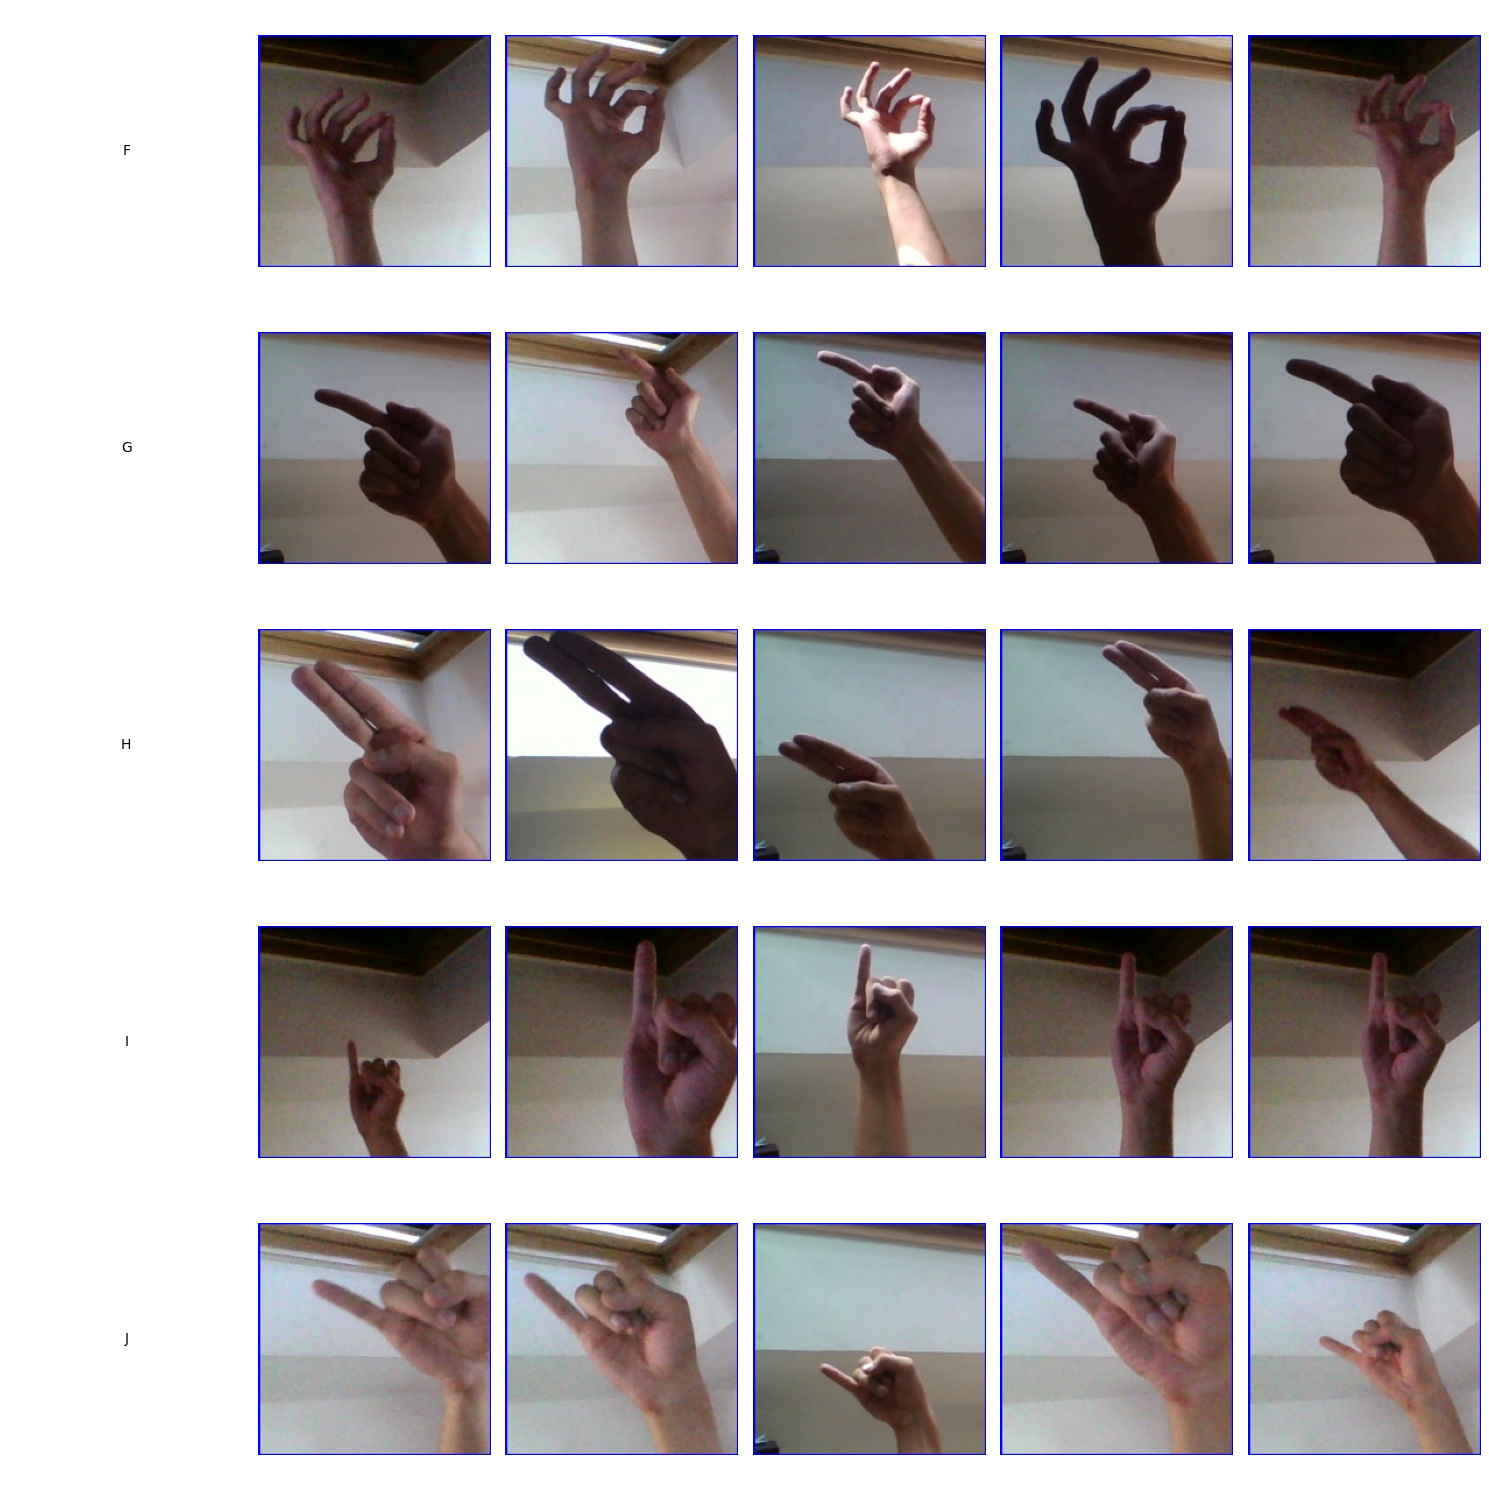

In [7]:
random_images(categories[5:10])

# Data preprocessing

In [8]:
path = []
label = []

for cat in categories:
    label_path = os.path.join(TRAIN_DIR, cat, "*")
    files = glob.glob(label_path)
    sign = [cat] * len(files)
    path.extend(files)
    label.extend(sign)

df = pd.DataFrame({
    'img_path': path,
    'img_label': label
})

df

img_path img_label
0      asl_alphabet_train/asl_alphabet_train/A/A2599.jpg         A
1      asl_alphabet_train/asl_alphabet_train/A/A2977.jpg         A
2      asl_alphabet_train/asl_alphabet_train/A/A1042.jpg         A
3      asl_alphabet_train/asl_alphabet_train/A/A2975.jpg         A
4      asl_alphabet_train/asl_alphabet_train/A/A1775.jpg         A
...                                                  ...       ...
86995  asl_alphabet_train/asl_alphabet_train/space/sp...     space
86996  asl_alphabet_train/asl_alphabet_train/space/sp...     space
86997  asl_alphabet_train/asl_alphabet_train/space/sp...     space
86998  asl_alphabet_train/asl_alphabet_train/space/sp...     space
86999  asl_alphabet_train/asl_alphabet_train/space/sp...     space

[87000 rows x 2 columns]

In [10]:
X_train,X_test,y_train,y_test = train_test_split(df['img_path'],df['img_label'],
                                             test_size=0.15,
                                             random_state=23,
                                             shuffle=True,
                                             stratify=df['img_label'])

train_data = pd.DataFrame({
    "img_path": X_train,
    "img_label": y_train
})

X_train,X_val,y_train,y_val = train_test_split(train_data['img_path'], train_data['img_label'],
                                              test_size=0.2,
                                              random_state=23,
                                              shuffle=True,
                                              stratify=train_data['img_label'])

train_data = pd.DataFrame({
    'img_path': X_train,
    'img_label': y_train
})
test_data = pd.DataFrame({
    'img_path': X_test,
    'img_label': y_test
})
val_data = pd.DataFrame({
    'img_path': X_val,
    'img_label': y_val
})


display(train_data)
display(val_data)
display(test_data)

img_path img_label
6236   asl_alphabet_train/asl_alphabet_train/C/C2580.jpg         C
86239  asl_alphabet_train/asl_alphabet_train/space/sp...     space
68906   asl_alphabet_train/asl_alphabet_train/W/W653.jpg         W
45655  asl_alphabet_train/asl_alphabet_train/P/P1667.jpg         P
44248   asl_alphabet_train/asl_alphabet_train/O/O502.jpg         O
...                                                  ...       ...
83116  asl_alphabet_train/asl_alphabet_train/nothing/...   nothing
86175  asl_alphabet_train/asl_alphabet_train/space/sp...     space
25597  asl_alphabet_train/asl_alphabet_train/I/I2437.jpg         I
24312  asl_alphabet_train/asl_alphabet_train/I/I2060.jpg         I
8224   asl_alphabet_train/asl_alphabet_train/C/C2409.jpg         C

[59160 rows x 2 columns]

img_path img_label
10366   asl_alphabet_train/asl_alphabet_train/D/D173.jpg         D
44056  asl_alphabet_train/asl_alphabet_train/O/O1687.jpg         O
28499  asl_alphabet_train/asl_alphabet_train/J/J2793.jpg         J
18887  asl_alphabet_train/asl_alphabet_train/G/G1735.jpg         G
74654   asl_alphabet_train/asl_alphabet_train/Y/Y741.jpg         Y
...                                                  ...       ...
9603   asl_alphabet_train/asl_alphabet_train/D/D2152.jpg         D
74645  asl_alphabet_train/asl_alphabet_train/Y/Y1190.jpg         Y
38816   asl_alphabet_train/asl_alphabet_train/M/M343.jpg         M
2449   asl_alphabet_train/asl_alphabet_train/A/A1515.jpg         A
32467  asl_alphabet_train/asl_alphabet_train/K/K2361.jpg         K

[14790 rows x 2 columns]

img_path img_label
5097   asl_alphabet_train/asl_alphabet_train/B/B2706.jpg         B
7369   asl_alphabet_train/asl_alphabet_train/C/C2284.jpg         C
12001  asl_alphabet_train/asl_alphabet_train/E/E2835.jpg         E
2235    asl_alphabet_train/asl_alphabet_train/A/A682.jpg         A
63613  asl_alphabet_train/asl_alphabet_train/V/V1507.jpg         V
...                                                  ...       ...
64277  asl_alphabet_train/asl_alphabet_train/V/V2264.jpg         V
6872   asl_alphabet_train/asl_alphabet_train/C/C1015.jpg         C
75897   asl_alphabet_train/asl_alphabet_train/Z/Z310.jpg         Z
38384   asl_alphabet_train/asl_alphabet_train/M/M740.jpg         M
65596  asl_alphabet_train/asl_alphabet_train/V/V2860.jpg         V

[13050 rows x 2 columns]

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    # validation_split=0.15
)
val_datagen = ImageDataGenerator(
   rescale=1/255.
)

In [12]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory='./',
    x_col = 'img_path',
    y_col = 'img_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory='./',
    x_col = 'img_path',
    y_col = 'img_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = val_datagen.flow_from_dataframe(
    dataframe=test_data,
    directory='./',
    x_col='img_path',
    y_col='img_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 59160 validated image filenames belonging to 29 classes.
Found 14790 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


# Creating Model

In [33]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=INPUT_SIZE))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.15))

model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(29,activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)      │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 512)               │  4,194,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_8 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 29)                │      7,453 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,380,861 (16.71 MB)

 Trainable params: 4,380,797 (16.71 MB)

 Non-trainable params: 64 (256.00 B)

In [46]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=10,
                                             restore_best_weights=True,
                                             verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                patience=5,
                                                factor=0.5,
                                                 min_lr=1e-5,
                                                 verbose=1)

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [36]:
tf.random.set_seed(23)

history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=150,
                    callbacks=[reduce_lr,stop_early])

Epoch 1/150


/home/szymon/Desktop/projects/ASL-Alphabet/tfod/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1849/1849 ━━━━━━━━━━━━━━━━━━━━ 98s 51ms/step - accuracy: 0.1057 - loss: 3.2770 - val_accuracy: 0.1692 - val_loss: 2.7266 - learning_rate: 0.0010
Epoch 2/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step - accuracy: 0.2277 - loss: 2.4954 - val_accuracy: 0.3381 - val_loss: 2.0811 - learning_rate: 0.0010
Epoch 3/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step - accuracy: 0.2936 - loss: 2.2254 - val_accuracy: 0.4297 - val_loss: 1.8159 - learning_rate: 0.0010
Epoch 4/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 91s 49ms/step - accuracy: 0.3442 - loss: 2.0383 - val_accuracy: 0.4978 - val_loss: 1.5826 - learning_rate: 0.0010
Epoch 5/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 91s 49ms/step - accuracy: 0.3802 - loss: 1.9229 - val_accuracy: 0.5371 - val_loss: 1.4683 - learning_rate: 0.0010
Epoch 6/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - accuracy: 0.4108 - loss: 1.8141 - val_accuracy: 0.5623 - val_loss: 1.3615 - learning_rate: 0.0010
Epoch 7/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 88s 47ms/step - accuracy: 0

In [37]:
model.evaluate(test_generator)

408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9160 - loss: 0.3171


[0.3237452805042267, 0.913409948348999]

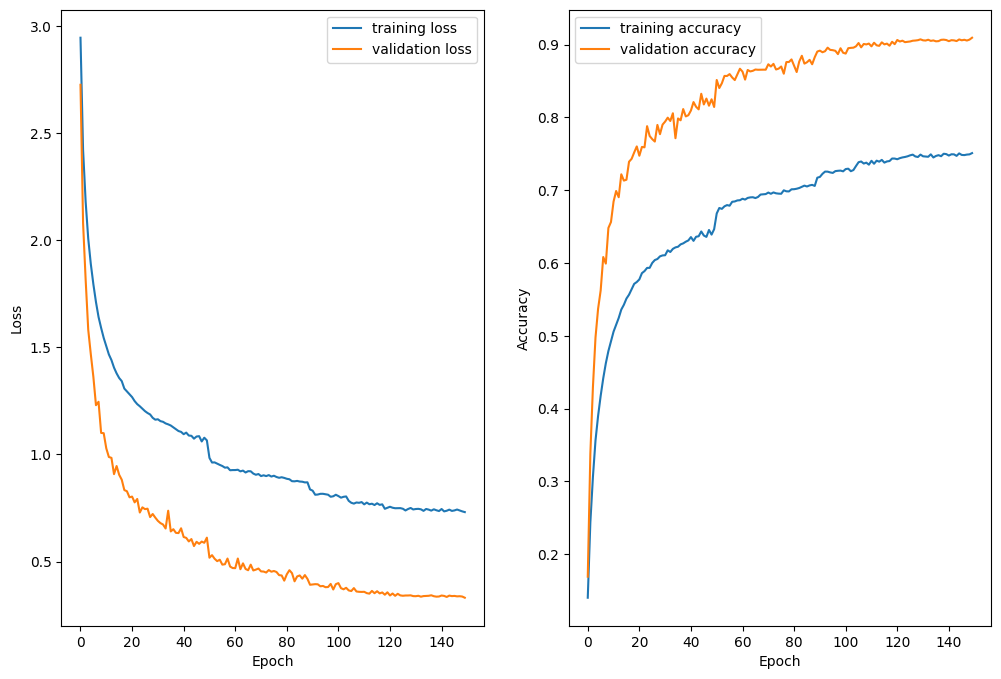

In [99]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(history.history['loss'], label='training loss')
ax1.plot(history.history['val_loss'], label='validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history.history['accuracy'], label='training accuracy')
ax2.plot(history.history['val_accuracy'], label='validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [53]:
model.save('models/model.keras')

In [13]:
model = tf.keras.models.load_model('models/model.keras')

2023-12-29 13:26:29.149629: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 13:26:29.149793: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-29 13:26:29.149910: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Evaluating model predictions

In [14]:
model.evaluate(test_generator)

/home/szymon/Desktop/projects/ASL-Alphabet/tfod/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2023-12-29 13:26:31.857428: I external/local_xla/xla/service/service.cc:168] XLA service 0x5556ec9a0790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-29 13:26:31.857454: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2023-12-29 13:26:31.866349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-29 13:26:31.905077: I external/local_xla/xla/stre

 19/408 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9176 - loss: 0.3295 

I0000 00:00:1703852792.574998   23613 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9097 - loss: 0.3348


[0.32381319999694824, 0.913409948348999]

In [92]:
model_predictions = model.predict(test_generator)
true_labels = test_generator.classes
conf_matrix = confusion_matrix(true_labels,
                               model_predictions.argmax(axis=1))

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


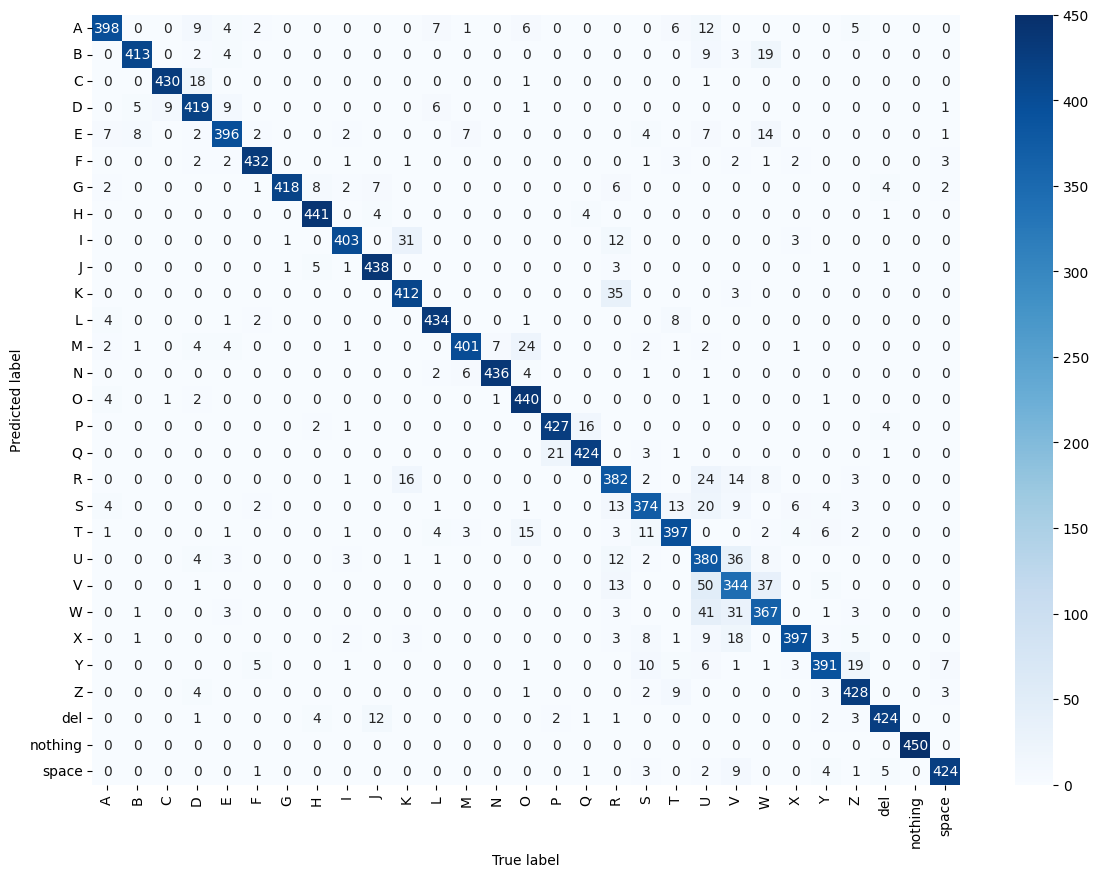

In [93]:
plt.figure(figsize=(14,10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [109]:
print(classification_report(true_labels,
                      model_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       450
           1       0.96      0.92      0.94       450
           2       0.98      0.96      0.97       450
           3       0.90      0.93      0.91       450
           4       0.93      0.88      0.90       450
           5       0.97      0.96      0.96       450
           6       1.00      0.93      0.96       450
           7       0.96      0.98      0.97       450
           8       0.96      0.90      0.93       450
           9       0.95      0.97      0.96       450
          10       0.89      0.92      0.90       450
          11       0.95      0.96      0.96       450
          12       0.96      0.89      0.92       450
          13       0.98      0.97      0.98       450
          14       0.89      0.98      0.93       450
          15       0.95      0.95      0.95       450
          16       0.95      0.94      0.95       450
          17       0.79    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

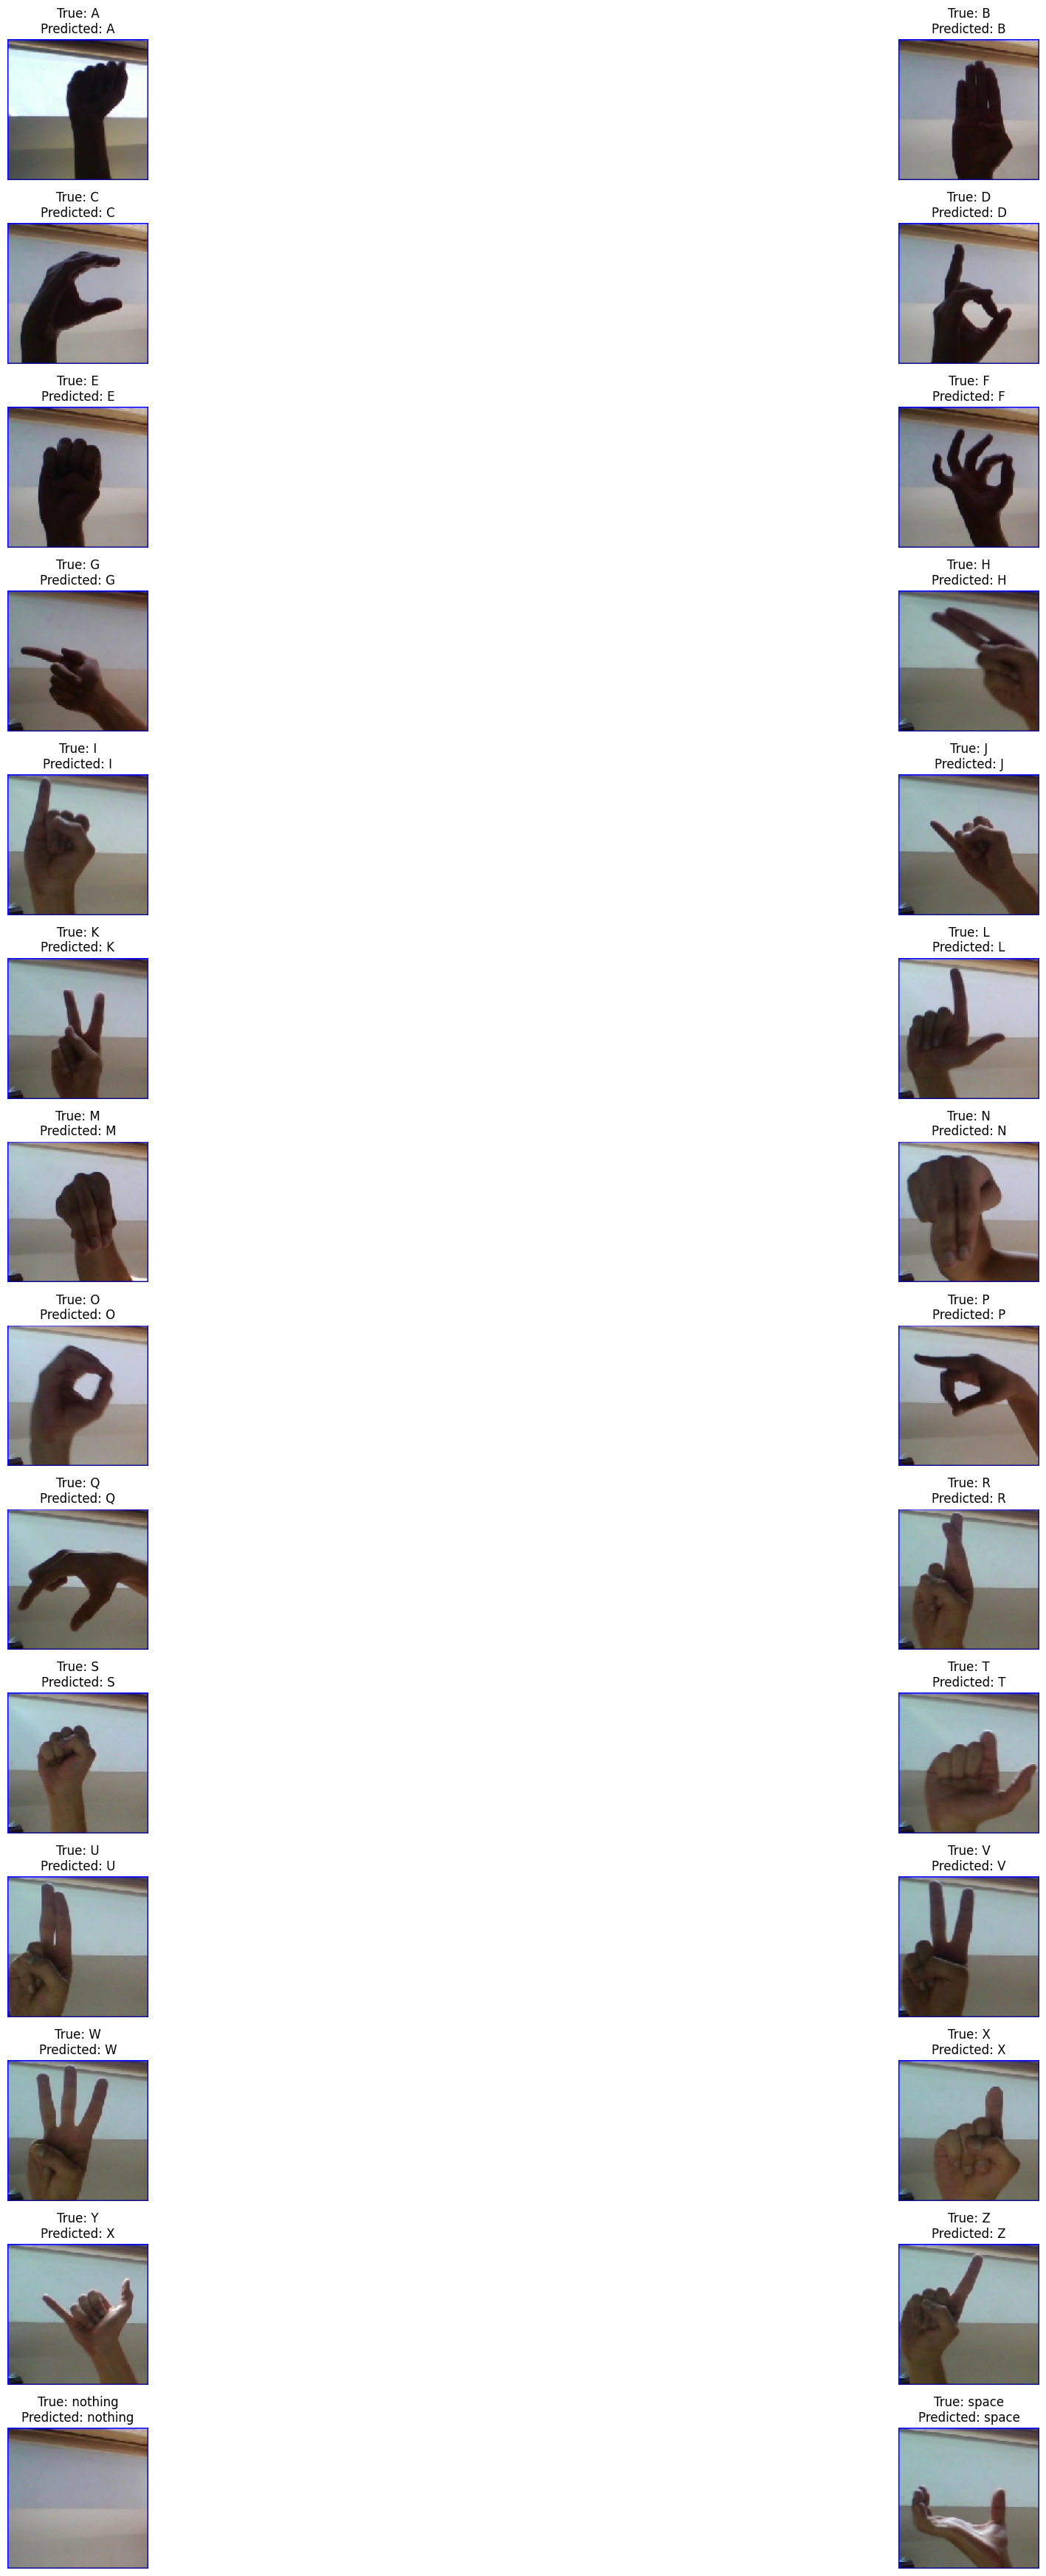

In [151]:
folder_path = 'asl_alphabet_test/asl_alphabet_test/'
files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
files.sort() 

fig, axes = plt.subplots(len(files) // 2, 2, figsize=(35, 35))

for i, filename in enumerate(files):
    img_path = os.path.join(folder_path, filename)
    
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    pred_cat = categories[predicted_class[0]]

    true_class = filename.split('_')[0] if '_' in filename else 'Unknown'

    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPredicted: {pred_cat}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model with dummies

In [13]:
train_dummies = pd.get_dummies(train_data, columns=['img_label'])
test_dummies = pd.get_dummies(test_data, columns=['img_label'])
val_dummies = pd.get_dummies(val_data, columns=['img_label'])
display(train_dummies)
display(test_dummies)
display(val_dummies)

img_path  img_label_A  \
6236   asl_alphabet_train/asl_alphabet_train/C/C2580.jpg        False   
86239  asl_alphabet_train/asl_alphabet_train/space/sp...        False   
68906   asl_alphabet_train/asl_alphabet_train/W/W653.jpg        False   
45655  asl_alphabet_train/asl_alphabet_train/P/P1667.jpg        False   
44248   asl_alphabet_train/asl_alphabet_train/O/O502.jpg        False   
...                                                  ...          ...   
83116  asl_alphabet_train/asl_alphabet_train/nothing/...        False   
86175  asl_alphabet_train/asl_alphabet_train/space/sp...        False   
25597  asl_alphabet_train/asl_alphabet_train/I/I2437.jpg        False   
24312  asl_alphabet_train/asl_alphabet_train/I/I2060.jpg        False   
8224   asl_alphabet_train/asl_alphabet_train/C/C2409.jpg        False   

       img_label_B  img_label_C  img_label_D  img_label_E  img_label_F  \
6236         False         True        False        False        False   
86239        False        False        False        False        False   
68906        False        False        False        False        False   
45655        False        False        False        False        False   
44248        False        False        False        False        False   
...            ...          ...          ...          ...          ...   
83116        False        False        False        False        False   
86175        False        False        False        False        False   
25597        False        False        False        False        False   
24312        False        False        False        False        False   
8224         False         True        False        False        False   

       img_label_G  img_label_H  img_label_I  ...  img_label_T  img_label_U  \
6236         False        False        False  ...        False        False   
86239        False        False        False  ...        False        False   
68906        False        False        False  ...        False        False   
45655        False        False        False  ...        False        False   
44248        False        False        False  ...        False        False   
...            ...          ...          ...  ...          ...          ...   
83116        False        False        False  ...        False        False   
86175        False        False        False  ...        False        False   
25597        False        False         True  ...        False        False   
24312        False        False         True  ...        False        False   
8224         False        False        False  ...        False        False   

       img_label_V  img_label_W  img_label_X  img_label_Y  img_label_Z  \
6236         False        False        False        False        False   
86239        False        False        False        False        False   
68906        False         True        False        False        False   
45655        False        False        False        False        False   
44248        False        False        False        False        False   
...            ...          ...          ...          ...          ...   
83116        False        False        False        False        False   
86175        False        False        False        False        False   
25597        False        False        False        False        False   
24312        False        False        False        False        False   
8224         False        False        False        False        False   

       img_label_del  img_label_nothing  img_label_space  
6236           False              False            False  
86239          False              False             True  
68906          False              False            False  
45655          False              False            False  
44248          False              False            False  
...              ...                ...              ...  
83116          False           

img_path  img_label_A  \
5097   asl_alphabet_train/asl_alphabet_train/B/B2706.jpg        False   
7369   asl_alphabet_train/asl_alphabet_train/C/C2284.jpg        False   
12001  asl_alphabet_train/asl_alphabet_train/E/E2835.jpg        False   
2235    asl_alphabet_train/asl_alphabet_train/A/A682.jpg         True   
63613  asl_alphabet_train/asl_alphabet_train/V/V1507.jpg        False   
...                                                  ...          ...   
64277  asl_alphabet_train/asl_alphabet_train/V/V2264.jpg        False   
6872   asl_alphabet_train/asl_alphabet_train/C/C1015.jpg        False   
75897   asl_alphabet_train/asl_alphabet_train/Z/Z310.jpg        False   
38384   asl_alphabet_train/asl_alphabet_train/M/M740.jpg        False   
65596  asl_alphabet_train/asl_alphabet_train/V/V2860.jpg        False   

       img_label_B  img_label_C  img_label_D  img_label_E  img_label_F  \
5097          True        False        False        False        False   
7369         False         True        False        False        False   
12001        False        False        False         True        False   
2235         False        False        False        False        False   
63613        False        False        False        False        False   
...            ...          ...          ...          ...          ...   
64277        False        False        False        False        False   
6872         False         True        False        False        False   
75897        False        False        False        False        False   
38384        False        False        False        False        False   
65596        False        False        False        False        False   

       img_label_G  img_label_H  img_label_I  ...  img_label_T  img_label_U  \
5097         False        False        False  ...        False        False   
7369         False        False        False  ...        False        False   
12001        False        False        False  ...        False        False   
2235         False        False        False  ...        False        False   
63613        False        False        False  ...        False        False   
...            ...          ...          ...  ...          ...          ...   
64277        False        False        False  ...        False        False   
6872         False        False        False  ...        False        False   
75897        False        False        False  ...        False        False   
38384        False        False        False  ...        False        False   
65596        False        False        False  ...        False        False   

       img_label_V  img_label_W  img_label_X  img_label_Y  img_label_Z  \
5097         False        False        False        False        False   
7369         False        False        False        False        False   
12001        False        False        False        False        False   
2235         False        False        False        False        False   
63613         True        False        False        False        False   
...            ...          ...          ...          ...          ...   
64277         True        False        False        False        False   
6872         False        False        False        False        False   
75897        False        False        False        False         True   
38384        False        False        False        False        False   
65596         True        False        False        False        False   

       img_label_del  img_label_nothing  img_label_space  
5097           False              False            False  
7369           False              False            False  
12001          False              False            False  
2235           False              False            False  
63613          False              False            False  
...              ...                ...              ...  
64277          False           

img_path  img_label_A  \
10366   asl_alphabet_train/asl_alphabet_train/D/D173.jpg        False   
44056  asl_alphabet_train/asl_alphabet_train/O/O1687.jpg        False   
28499  asl_alphabet_train/asl_alphabet_train/J/J2793.jpg        False   
18887  asl_alphabet_train/asl_alphabet_train/G/G1735.jpg        False   
74654   asl_alphabet_train/asl_alphabet_train/Y/Y741.jpg        False   
...                                                  ...          ...   
9603   asl_alphabet_train/asl_alphabet_train/D/D2152.jpg        False   
74645  asl_alphabet_train/asl_alphabet_train/Y/Y1190.jpg        False   
38816   asl_alphabet_train/asl_alphabet_train/M/M343.jpg        False   
2449   asl_alphabet_train/asl_alphabet_train/A/A1515.jpg         True   
32467  asl_alphabet_train/asl_alphabet_train/K/K2361.jpg        False   

       img_label_B  img_label_C  img_label_D  img_label_E  img_label_F  \
10366        False        False         True        False        False   
44056        False        False        False        False        False   
28499        False        False        False        False        False   
18887        False        False        False        False        False   
74654        False        False        False        False        False   
...            ...          ...          ...          ...          ...   
9603         False        False         True        False        False   
74645        False        False        False        False        False   
38816        False        False        False        False        False   
2449         False        False        False        False        False   
32467        False        False        False        False        False   

       img_label_G  img_label_H  img_label_I  ...  img_label_T  img_label_U  \
10366        False        False        False  ...        False        False   
44056        False        False        False  ...        False        False   
28499        False        False        False  ...        False        False   
18887         True        False        False  ...        False        False   
74654        False        False        False  ...        False        False   
...            ...          ...          ...  ...          ...          ...   
9603         False        False        False  ...        False        False   
74645        False        False        False  ...        False        False   
38816        False        False        False  ...        False        False   
2449         False        False        False  ...        False        False   
32467        False        False        False  ...        False        False   

       img_label_V  img_label_W  img_label_X  img_label_Y  img_label_Z  \
10366        False        False        False        False        False   
44056        False        False        False        False        False   
28499        False        False        False        False        False   
18887        False        False        False        False        False   
74654        False        False        False         True        False   
...            ...          ...          ...          ...          ...   
9603         False        False        False        False        False   
74645        False        False        False         True        False   
38816        False        False        False        False        False   
2449         False        False        False        False        False   
32467        False        False        False        False        False   

       img_label_del  img_label_nothing  img_label_space  
10366          False              False            False  
44056          False              False            False  
28499          False              False            False  
18887          False              False            False  
74654          False              False            False  
...              ...                ...              ...  
9603           False           

In [79]:
train_generator_dummies = train_datagen.flow_from_dataframe(
    dataframe=train_dummies,
    directory='./',
    x_col = 'img_path',
    y_col = train_dummies.columns[1:],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

val_generator_dummies = val_datagen.flow_from_dataframe(
    dataframe=val_dummies,
    directory='./',
    x_col = 'img_path',
    y_col = val_dummies.columns[1:],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw'
)
test_generator_dummies = val_datagen.flow_from_dataframe(
    dataframe=test_dummies,
    directory='./',
    x_col='img_path',
    y_col=test_dummies.columns[1:],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 59160 validated image filenames.
Found 14790 validated image filenames.
Found 13050 validated image filenames.


In [40]:
model_dummies = tf.keras.models.clone_model(model)
model_dummies.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)      │        896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)      │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 32)        │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)        │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 512)               │  4,194,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_8 (Dropout)             │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 29)                │      7,453 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 4,380,861 (16.71 MB)

 Trainable params: 4,380,797 (16.71 MB)

 Non-trainable params: 64 (256.00 B)

In [41]:
model_dummies.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [47]:
tf.random.set_seed(23)

history_dummies = model_dummies.fit(train_generator_dummies,
                    validation_data=val_generator_dummies,
                    epochs=150,
                    callbacks=[stop_early,reduce_lr])

Epoch 1/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - accuracy: 0.2995 - loss: 2.2106 - val_accuracy: 0.4571 - val_loss: 1.7323 - learning_rate: 0.0010
Epoch 2/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step - accuracy: 0.3484 - loss: 2.0394 - val_accuracy: 0.4329 - val_loss: 1.7029 - learning_rate: 0.0010
Epoch 3/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 49ms/step - accuracy: 0.3793 - loss: 1.9376 - val_accuracy: 0.5552 - val_loss: 1.4750 - learning_rate: 0.0010
Epoch 4/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.4059 - loss: 1.8531 - val_accuracy: 0.5840 - val_loss: 1.3788 - learning_rate: 0.0010
Epoch 5/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 49ms/step - accuracy: 0.4264 - loss: 1.7774 - val_accuracy: 0.5672 - val_loss: 1.3856 - learning_rate: 0.0010
Epoch 6/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 92s 50ms/step - accuracy: 0.4382 - loss: 1.7301 - val_accuracy: 0.6193 - val_loss: 1.2575 - learning_rate: 0.0010
Epoch 7/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step -

In [48]:
model_dummies.evaluate(test_generator_dummies)

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9235 - loss: 0.2927


[0.2912790775299072, 0.9247509837150574]

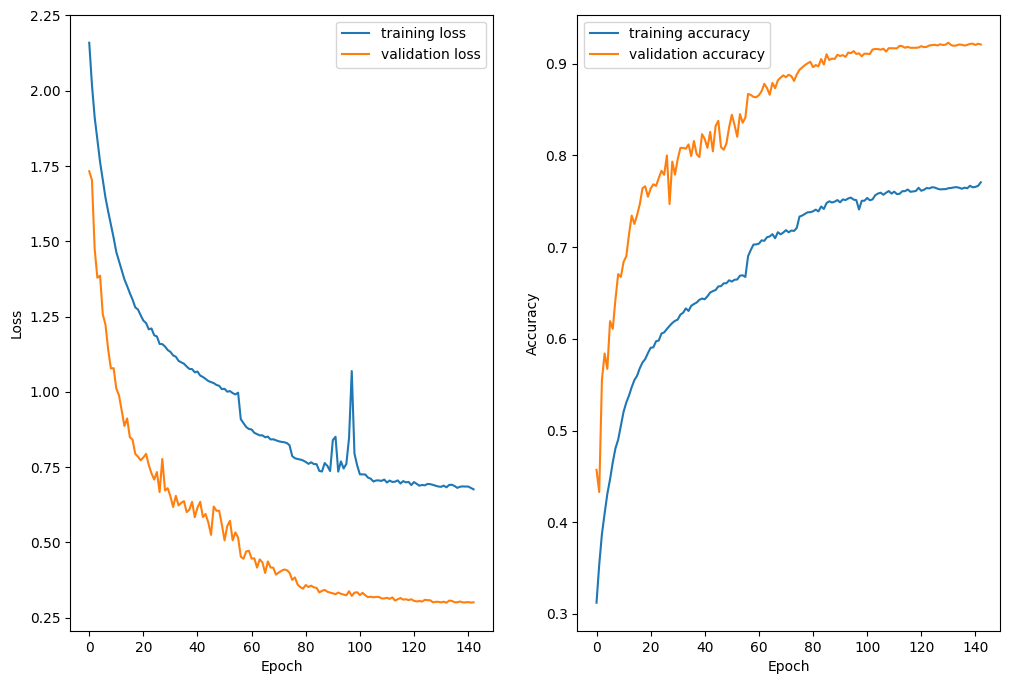

In [100]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(history_dummies.history['loss'], label='training loss')
ax1.plot(history_dummies.history['val_loss'], label='validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history_dummies.history['accuracy'], label='training accuracy')
ax2.plot(history_dummies.history['val_accuracy'], label='validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [52]:
model_dummies.save('models/dummie_model.keras')

In [77]:
model_dummies = tf.keras.models.load_model('models/dummie_model.keras')
model_dummies.evaluate(test_generator_dummies)

408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9271 - loss: 0.2859


[0.2911641597747803, 0.9247509837150574]

In [52]:
model_dummies_preds = model_dummies.predict(test_generator_dummies)

408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [96]:
label_binarizer = LabelBinarizer()
true_labels_onehot = label_binarizer.fit_transform(true_labels)

model_predictions_dummies = model_dummies.predict(test_generator_dummies)
conf_matrix_dummies = confusion_matrix(true_labels_onehot.argmax(axis=1),
                                       model_predictions_dummies.argmax(axis=1))


408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


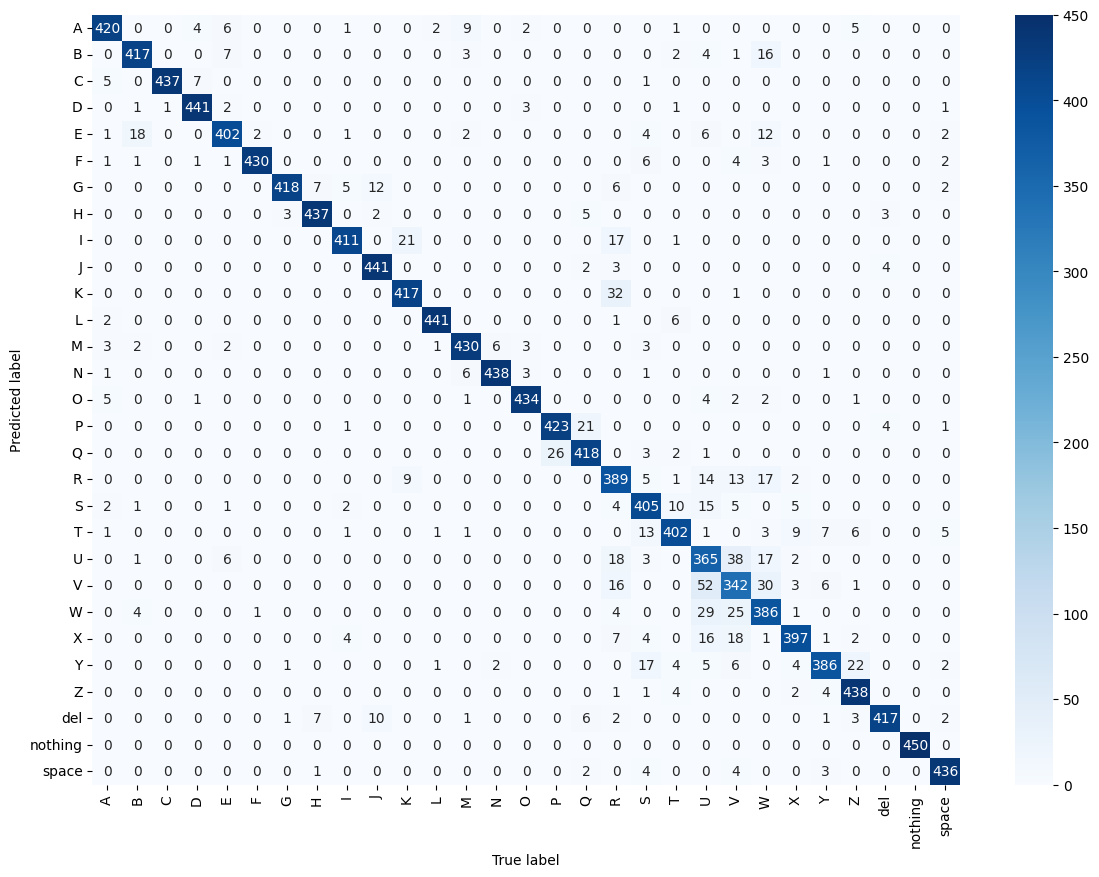

In [97]:
plt.figure(figsize=(14,10))
sns.heatmap(conf_matrix_dummies, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [111]:
print(classification_report(true_labels_onehot.argmax(axis=1),
                            model_predictions_dummies.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       450
           1       0.94      0.93      0.93       450
           2       1.00      0.97      0.98       450
           3       0.97      0.98      0.98       450
           4       0.94      0.89      0.92       450
           5       0.99      0.96      0.97       450
           6       0.99      0.93      0.96       450
           7       0.97      0.97      0.97       450
           8       0.96      0.91      0.94       450
           9       0.95      0.98      0.96       450
          10       0.93      0.93      0.93       450
          11       0.99      0.98      0.98       450
          12       0.95      0.96      0.95       450
          13       0.98      0.97      0.98       450
          14       0.98      0.96      0.97       450
          15       0.94      0.94      0.94       450
          16       0.92      0.93      0.92       450
          17       0.78    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

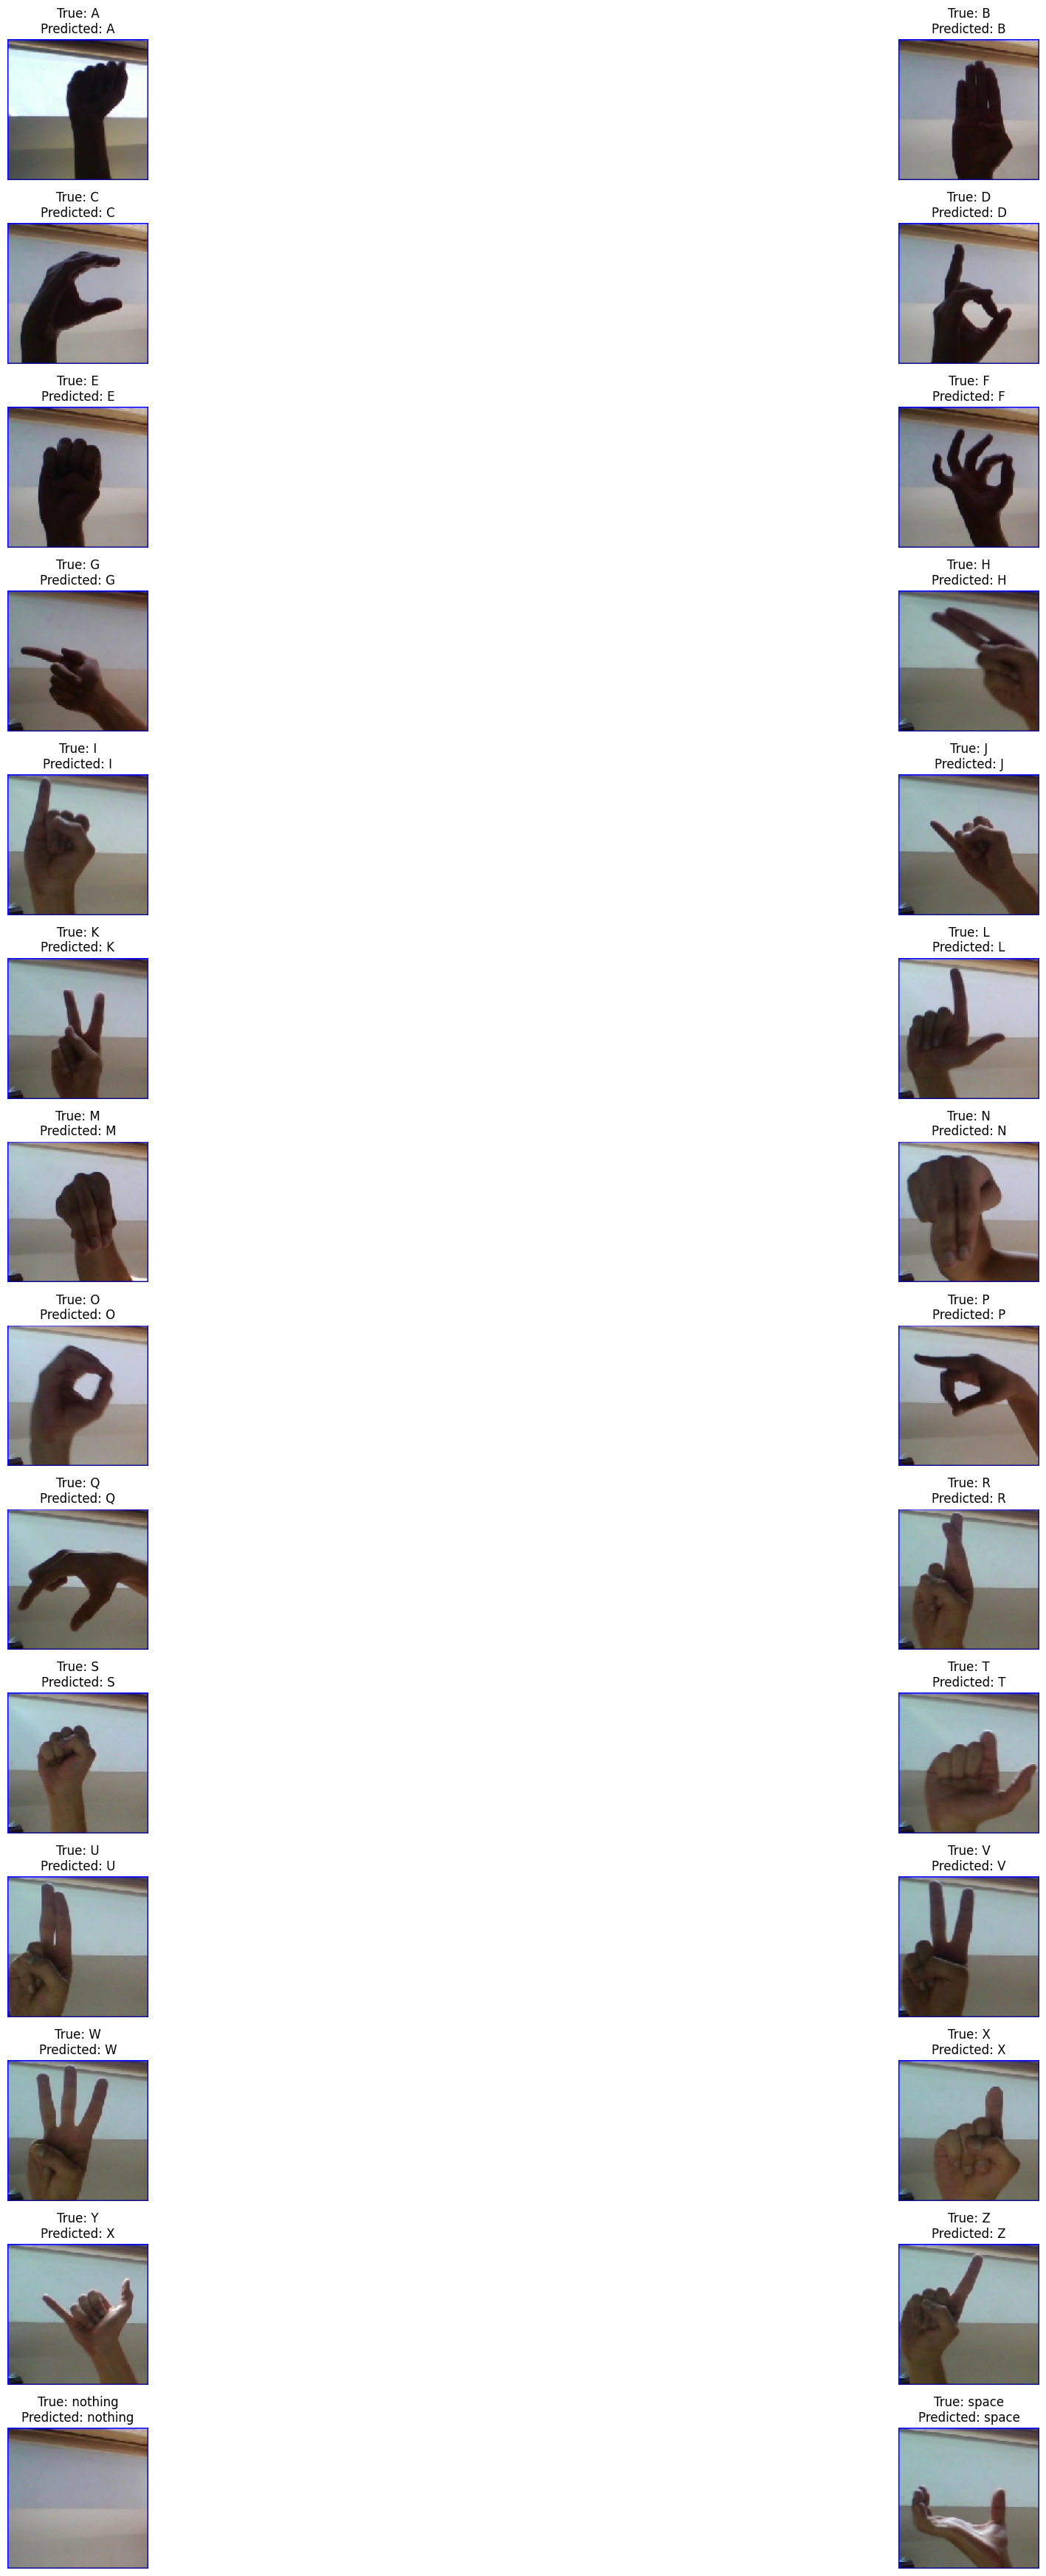

In [152]:
files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
files.sort() 

fig, axes = plt.subplots(len(files) // 2, 2, figsize=(35, 35))

for i, filename in enumerate(files):
    img_path = os.path.join(folder_path, filename)
    
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model_dummies.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    pred_cat = categories[predicted_class[0]]

    true_class = filename.split('_')[0] if '_' in filename else 'Unknown'

    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPredicted: {pred_cat}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# VGG16 Model

In [58]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_SIZE)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=predictions)

model_vgg16.summary()

Model: "functional_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)      │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)      │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)       │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)       │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)       │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 512)               │  4,194,816 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_13 (Dropout)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 512)               │    262,656 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_14 (Dropout)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 512)               │    262,65

 Total params: 19,449,693 (74.19 MB)

 Trainable params: 4,735,005 (18.06 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [60]:
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [101]:
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=[stop_early,reduce_lr]
)

Epoch 1/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 88s 48ms/step - accuracy: 0.6405 - loss: 1.0739 - val_accuracy: 0.8750 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 2/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 87s 47ms/step - accuracy: 0.6898 - loss: 0.9291 - val_accuracy: 0.8794 - val_loss: 0.3961 - learning_rate: 0.0010
Epoch 3/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 91s 49ms/step - accuracy: 0.7171 - loss: 0.8495 - val_accuracy: 0.9077 - val_loss: 0.3238 - learning_rate: 0.0010
Epoch 4/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 89s 48ms/step - accuracy: 0.7301 - loss: 0.8088 - val_accuracy: 0.9170 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 5/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step - accuracy: 0.7384 - loss: 0.7915 - val_accuracy: 0.9081 - val_loss: 0.3319 - learning_rate: 0.0010
Epoch 6/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 49ms/step - accuracy: 0.7452 - loss: 0.7625 - val_accuracy: 0.8935 - val_loss: 0.3498 - learning_rate: 0.0010
Epoch 7/150
1849/1849 ━━━━━━━━━━━━━━━━━━━━ 90s 48ms/step -

In [102]:
model_vgg16.evaluate(test_generator)

408/408 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9761 - loss: 0.0936


[0.09381099790334702, 0.976321816444397]

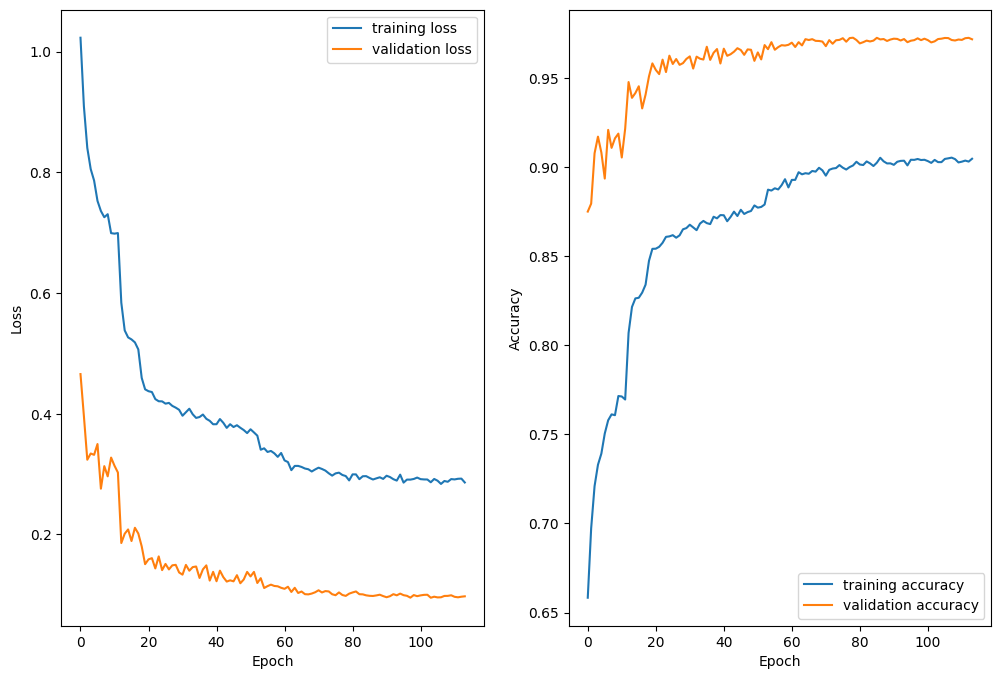

In [103]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))

ax1.plot(history_vgg16.history['loss'], label='training loss')
ax1.plot(history_vgg16.history['val_loss'], label='validation loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(history_vgg16.history['accuracy'], label='training accuracy')
ax2.plot(history_vgg16.history['val_accuracy'], label='validation accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

In [104]:
model_vgg16.save('models/model_vgg16.keras')

In [99]:
model_vgg16 = tf.keras.models.load_model('models/model_vgg16.keras')
model_vgg16.evaluate(test_generator)

/home/szymon/Desktop/projects/ASL-Alphabet/tfod/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:388: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 70 variables whereas the saved optimizer has 18 variables. 



408/408 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9754 - loss: 0.0940


[0.09395100176334381, 0.976321816444397]

In [100]:
model_vgg16_preds = model_vgg16.predict(test_generator)

408/408 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step


In [105]:
conf_matrix_vgg16 = confusion_matrix(true_labels,
                               model_vgg16_preds.argmax(axis=1))

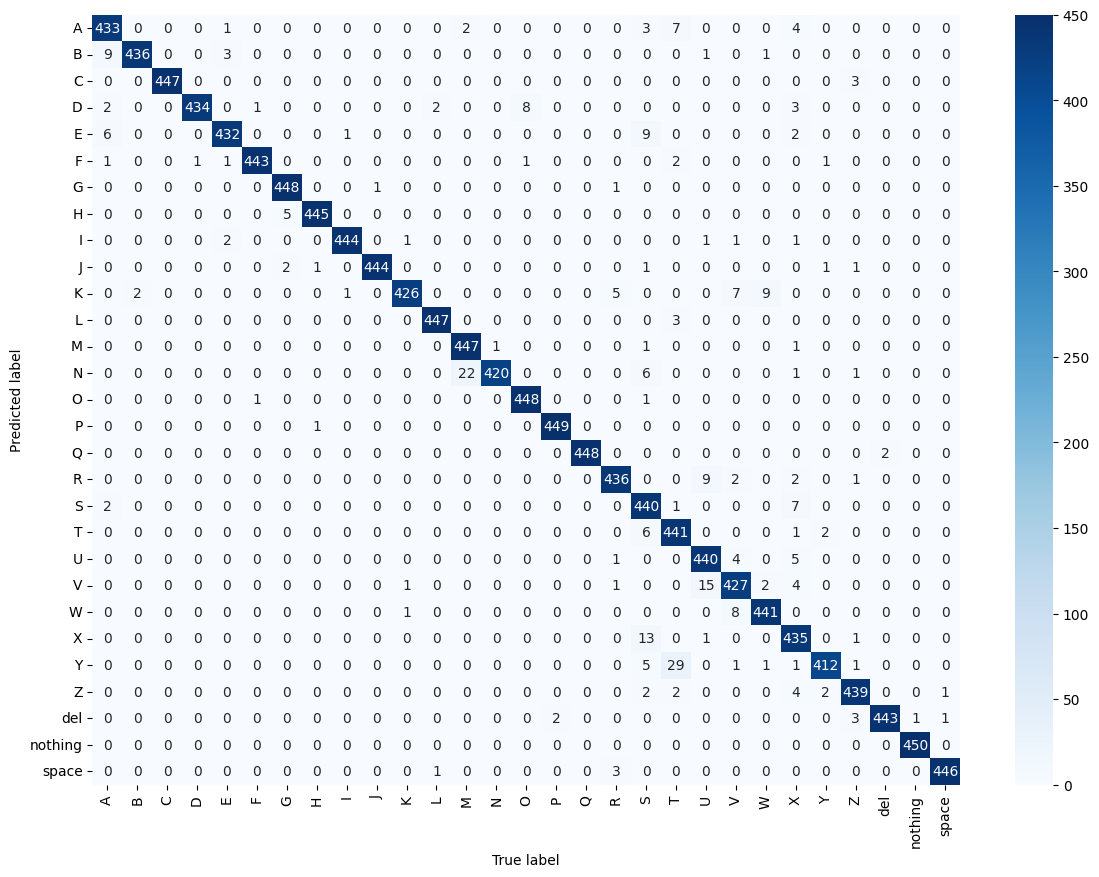

In [106]:
plt.figure(figsize=(14,10))
sns.heatmap(conf_matrix_vgg16, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(),)
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

In [110]:
print(classification_report(true_labels,
                      model_vgg16_preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       450
           1       1.00      0.97      0.98       450
           2       1.00      0.99      1.00       450
           3       1.00      0.96      0.98       450
           4       0.98      0.96      0.97       450
           5       1.00      0.98      0.99       450
           6       0.98      1.00      0.99       450
           7       1.00      0.99      0.99       450
           8       1.00      0.99      0.99       450
           9       1.00      0.99      0.99       450
          10       0.99      0.95      0.97       450
          11       0.99      0.99      0.99       450
          12       0.95      0.99      0.97       450
          13       1.00      0.93      0.96       450
          14       0.98      1.00      0.99       450
          15       1.00      1.00      1.00       450
          16       1.00      1.00      1.00       450
          17       0.98    

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/

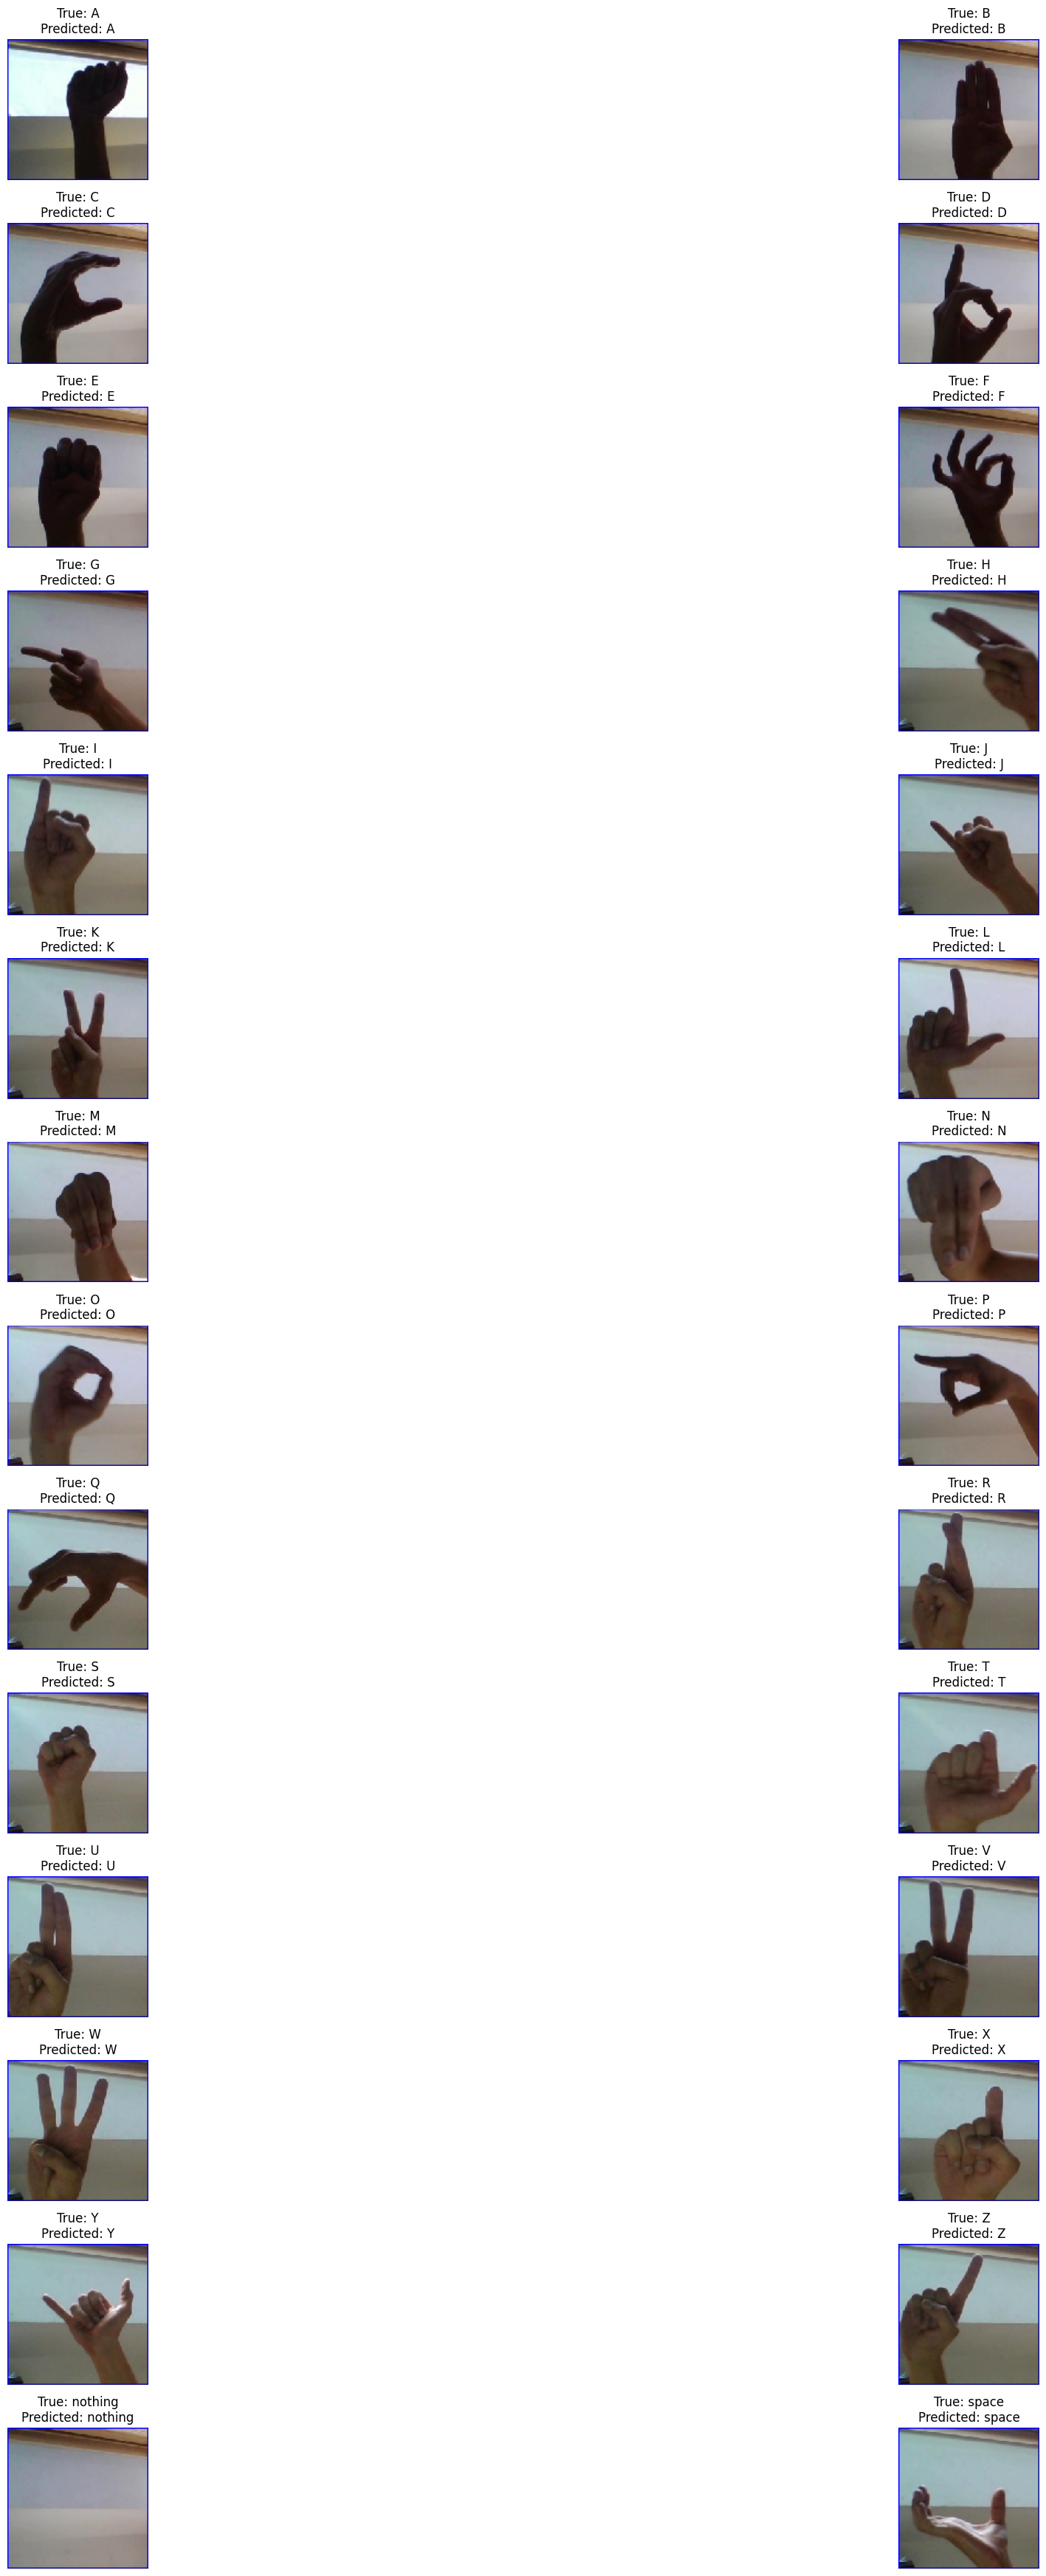

In [153]:
folder_path = 'asl_alphabet_test/asl_alphabet_test/'
files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
files.sort() 

fig, axes = plt.subplots(len(files) // 2, 2, figsize=(35, 35))

for i, filename in enumerate(files):
    img_path = os.path.join(folder_path, filename)
    
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    predictions = model_vgg16.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    pred_cat = categories[predicted_class[0]]

    true_class = filename.split('_')[0] if '_' in filename else 'Unknown'

    ax = axes[i // 2, i % 2]
    ax.imshow(img)
    ax.set_title(f'True: {true_class}\nPredicted: {pred_cat}')
    ax.axis('off')

plt.tight_layout()
plt.show()